<a href="https://colab.research.google.com/github/yurigalindo/DeepLearningMeteors/blob/master/Comparing_Splits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%%capture
!unzip /content/gdrive/My\ Drive/Splits -d IC

In [3]:
!ls IC

Meteoros       test_dates.csv	 train_places.csv   valid_shuffle.csv
new_test.csv   test_places.csv	 train_shuffle.csv
new_train.csv  test_shuffle.csv  valid_dates.csv
new_valid.csv  train_dates.csv	 valid_places.csv


In [0]:
#General imports
from __future__ import print_function, division 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage import io, transform
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
#Utilities for loading the images and creating datasets

import os
import os.path
from torch.utils.data import Dataset
from torchvision import get_image_backend

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def default_loader(path):
  if get_image_backend() == 'accimage':
    return accimage_loader(path)
  else:
    return pil_loader(path)
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
      return pil_loader(path)

class ImageFromCSV(Dataset):
    """Class for creating an image dataset based on a csv with filenames and
    a directory containing the images
    """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        image = default_loader(img_name)
        label = self.csv.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image , label

In [0]:
#Creation of datasets

#Transforms to convert the input into the input expected by resnet
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
}

image_datasets = dict()


#Creates datasets and stores them in a dictionary
for split in ['places','dates','shuffle']:
  image_datasets[split] = {x:ImageFromCSV("IC/{0}_{1}.csv".format(x,split),"IC/Meteoros",transform=data_transforms[x])
                  for x in ['train', 'valid','test']}

In [25]:
print(image_datasets)

{'places': {'train': <__main__.ImageFromCSV object at 0x7f381d24dba8>, 'valid': <__main__.ImageFromCSV object at 0x7f381d24d7b8>, 'test': <__main__.ImageFromCSV object at 0x7f381ca49780>}, 'dates': {'train': <__main__.ImageFromCSV object at 0x7f381d24db00>, 'valid': <__main__.ImageFromCSV object at 0x7f381d24d898>, 'test': <__main__.ImageFromCSV object at 0x7f381d24dc50>}, 'shuffle': {'train': <__main__.ImageFromCSV object at 0x7f38882fc2e8>, 'valid': <__main__.ImageFromCSV object at 0x7f381c981208>, 'test': <__main__.ImageFromCSV object at 0x7f381c981320>}}


In [7]:
#Displaying one image from the dataset for debugging purposes

dataloader=torch.utils.data.DataLoader(image_datasets['shuffle']['train'])
plt.ion() 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes.item())

KeyError: ignored

In [0]:
import matplotlib.pyplot as plt
import torch

class Learner:
    """Class for wrapping a model with training and prediction functionality.
    Stores an optimizer, a training criterion, and datasets. These can be altered
    throught set functions.
    """
    def __init__(self,model,criterion):
        self.model=model
        self.criterion=criterion
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.best_acc=0
        self.last_acc=0

    def set_datasets(self,training,valid):
        self.training_dataset=training
        self.validation_dataset=valid
    def set_optimizer(self,optimizer,scheduler):
        self.optimizer=optimizer
        self.scheduler=scheduler
    def propagate_batch(self,inputs,labels):
        with torch.set_grad_enabled(True):
            outputs=self.model(inputs)
            size=inputs.size(0)
            del inputs
            loss = self.criterion(outputs, labels)
            loss.backward()
            
        with torch.no_grad():
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item() 
            loss_item=loss.item()
        del preds
        del outputs
        del loss
        del labels
        return loss_item*size,corrects

    def eval_batch(self, inputs, labels):
        with torch.no_grad():
            outputs=self.model(inputs)
            loss = self.criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item()
            size=inputs.size(0)
            loss_item=loss.item()
        del outputs
        del loss
        del preds
        del inputs
        del labels
        return loss_item*size,corrects

    def print_statistics(self,loss,accuracy):
        print("  Avg Loss={}\n  Accuracy={}".format(loss,accuracy))
    def ceildiv(self,a, b):
        """Return the celing of the division of a by b
        """
        return -(-a // b)
    def min_value(self,a,b):
        """Return the smaller of two values
        """
        if a>b:
            return b
        else:
            return a
    def max_value(self,a,b):
        """"Return the greater of two values
        """
        if b>a:
          return b
        else:
          return a
    def change_to_best_model(self):
        self.model.load_state_dict(self.best_model_wts)
    def train(self,num_epochs,training_batchsize,validation_batchsize,batch_cap=32):
        """Train the learner's model for num_epochs on training batchsize, printing the train and validation loss and accuracy
        """
        batch_cap=self.min_value(training_batchsize,batch_cap)
        train_dataloader=torch.utils.data.DataLoader(self.training_dataset,batch_size=batch_cap,shuffle=True)
        
        training_batches=self.ceildiv(len(self.training_dataset),training_batchsize)
        micro_batches=training_batchsize//batch_cap #accuracy statistics will only work properly if training batch is divisible by batch_cap
        valid_dataloader=torch.utils.data.DataLoader(self.validation_dataset,batch_size=validation_batchsize,shuffle=True)
        validation_batches=self.ceildiv(len(self.validation_dataset),validation_batchsize)
        since = time.time()
        train_losses=[]
        valid_losses=[]
        for epoch in range(num_epochs):
            print("Epoch {} of {}".format(epoch,num_epochs-1))
            
            

            self.model.train()
            #Train model
            loss = 0
            corrects = 0
            iterator = iter(train_dataloader)
            for batch in range(training_batches):
                self.optimizer.zero_grad()
                try:
                  for micro_batch in range(micro_batches):

                    inputs,labels=next(iterator)
                    new_loss , new_corrects = self.propagate_batch(inputs.to(self.device),labels.to(self.device))
                    loss+=new_loss
                    corrects+=new_corrects
                    del inputs
                    del labels
                    del new_loss
                    del new_corrects
                    torch.cuda.empty_cache()
                except StopIteration:
                    pass
                self.optimizer.step()
                torch.cuda.empty_cache()

            self.scheduler.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
            train_losses.append(loss/len(self.training_dataset))
            print("Training:")
            self.print_statistics(loss/len(self.training_dataset),corrects/len(self.training_dataset))
            
            
            self.model.eval()
            #Evaluate model
            loss = 0
            corrects = 0
            iterator = iter(valid_dataloader)
            for batch in range(validation_batches):
                inputs,labels=next(iterator)
                new_loss , new_corrects=self.eval_batch(inputs.to(self.device),labels.to(self.device))
                loss+=new_loss
                corrects+=new_corrects
                del inputs
                del labels
                del new_loss
                del new_corrects
                torch.cuda.empty_cache()
            valid_losses.append(loss/len(self.validation_dataset))
            acc=corrects/len(self.validation_dataset)
            print("Validation:")
            self.print_statistics(loss/len(self.validation_dataset),acc)
            print()
            self.last_acc=acc
            if(acc>self.best_acc):
              self.best_acc=acc
              self.best_model_wts = copy.deepcopy(self.model.state_dict())
            

        time_elapsed = time.time() - since
        print("Total time:{}".format(time_elapsed))
        plt.plot(range(num_epochs),train_losses,'r',range(num_epochs),valid_losses,'b')
        del train_dataloader
        del valid_dataloader
        del train_losses
        del valid_losses
        torch.cuda.empty_cache()
    def predict(self,dataset,batchsize,num_classes):
        """Predicts on a dataset and returns a tensor containing the probabilities of each class 
        """
        dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
        dataset_len=len(dataset)
        num_batches=self.ceildiv(dataset_len,batchsize)
        since = time.time()
        predictions = torch.zeros((len(dataset),num_classes)).to(self.device)
        self.model.eval()
        self.optimizer.zero_grad()
        iterator = iter(dataloader)
        with torch.no_grad():
          for batch in range(num_batches):
              inputs, _ = next(iterator)
              inputs = inputs.to(self.device)
              logits =  self.model(inputs)
              del inputs
              unnormalized_probabilities = torch.exp(logits)
              del logits
              denominators = torch.sum(unnormalized_probabilities,1,True)
              probabilities= torch.div(unnormalized_probabilities,denominators)
              del denominators
              del unnormalized_probabilities
              indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
              predictions.index_copy_(0,indexes,probabilities)
              del indexes
              del probabilities
              torch.cuda.empty_cache()
          predictions_cpu=predictions.cpu()
        del predictions
        del dataloader
        torch.cuda.empty_cache()
        return predictions_cpu

In [0]:
def freeze_resnet(model,n):
  """Function that freezes the first n layers of a resnet
  """
  #This is considered as the first layer
  model.conv1.requires_grad=False
  model.bn1.weight.requires_grad=False
  model.bn1.bias.requires_grad=False
  l=1
  flag=False #Flag for stopping the iteration
  for layer in [model.layer1,model.layer2,model.layer3,model.layer4]:
    #Resnets group the layers on these 4 layer blocks
    if(flag):
      break
    for block in layer:
      if(flag):
        break
      for module in block.children():
        if(l<n):
          #Code for making the conv and batch norm layers untrainable
          if isinstance(module,nn.Conv2d):
            module.requires_grad=False
          elif isinstance(module,nn.BatchNorm2d):
            module.weight.requires_grad=False
            module.bias.requires_grad=False
            l+=1 #Counts each conv + batch group as one layer
        else:
          flag=True
          break
  

In [0]:
def accuracy_confidence(predictions,labels,threshold=0.5):
  """Given a confidence threshold, takes into account only the predictions above the threshold
  and evaluates accuracy, precision, recall and coverage
  """
  threshold = min(threshold,1-threshold)
  clip_preds = predictions.copy()
  clip_preds[clip_preds>=0.5]=1
  clip_preds[clip_preds<0.5]=0
  mask = np.logical_or(predictions<=threshold,predictions>=1-threshold) #mask for predictions above the threshold
  predicted = mask.sum()
  right_answers = clip_preds == labels
  right_answers[np.logical_not(mask)] = False #answers that were not predicted are not counted as correct
  correct = right_answers.sum()
  if predicted == 0:
    acc =0
  else:
    acc = correct/predicted

  predicted_meteors = clip_preds == 0
  predicted_meteors[np.logical_not(mask)] = False #removing meteors not predicted on
  true_positives = right_answers[predicted_meteors].sum()
  if true_positives == 0:
    precision = recall = 0
  else:
    precision = true_positives/predicted_meteors.sum()
    true_meteors = labels == 0
    true_meteors[np.logical_not(mask)] = False #disconsider the true meteors not predicted on
    recall = true_positives/true_meteors.sum()

  coverage = predicted/len(labels)
  return {'acc':acc ,'cov': coverage , 'prec':precision , 'rec':recall}
  


Epoch 0 of 29
Training:
  Avg Loss=0.26278085543045177
  Accuracy=0.8831097727894881
Validation:
  Avg Loss=0.25624258293656405
  Accuracy=0.875751503006012

Epoch 1 of 29
Training:
  Avg Loss=0.11822499052126571
  Accuracy=0.9575691212701889
Validation:
  Avg Loss=0.1826133488533731
  Accuracy=0.9298597194388778

Epoch 2 of 29
Training:
  Avg Loss=0.07730387205443104
  Accuracy=0.973172734738571
Validation:
  Avg Loss=0.12361023925946567
  Accuracy=0.9679358717434869

Epoch 3 of 29
Training:
  Avg Loss=0.05055299310725975
  Accuracy=0.9822064056939501
Validation:
  Avg Loss=0.21842508928809232
  Accuracy=0.9619238476953907

Epoch 4 of 29
Training:
  Avg Loss=0.060004985139952796
  Accuracy=0.9794689296468656
Validation:
  Avg Loss=0.13068206856150427
  Accuracy=0.9659318637274549

Epoch 5 of 29
Training:
  Avg Loss=0.07235062424202603
  Accuracy=0.9756364631809472
Validation:
  Avg Loss=0.1649331165578418
  Accuracy=0.9539078156312625

Epoch 6 of 29
Training:
  Avg Loss=0.069224071370

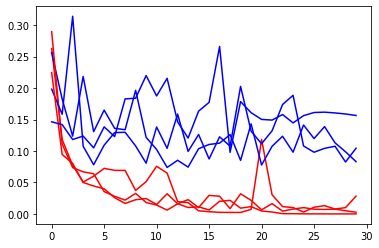

In [14]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for split in image_datasets:
  #Initializes model with the hyperparameters
  model_ft = models.resnet50(pretrained=True)
  freeze_resnet(model_ft,33)
  num_ftrs=model_ft.fc.in_features
  model_ft.fc=nn.Sequential(  nn.Linear(num_ftrs, 1024),
                              nn.ReLU(),
                              nn.Linear(1024, 2),
                            )
  model_ft=model_ft.to(device)
  criterion = nn.CrossEntropyLoss()
  learner = Learner(model_ft,criterion)

  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 3e-4)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.99)
  learner.set_optimizer(optimizer,scheduler)


  #trains on the training dataset for 30 epochs and changes to the best model on
  #the validation set (early stopping)
  learner.set_datasets(image_datasets[split]['train'],image_datasets[split]['valid'])
  learner.train(30,64,128,batch_cap=64)
  learner.change_to_best_model()

  #evaluates performance on the test set
  preds = learner.predict(image_datasets[split]['test'],128,2)
  preds[torch.isnan(preds)]=1 #some images may have excessive glitches that result in nan output 
                              #these images can be discarded as non meteors
  preds = preds[:,1].numpy() #Predicted probability of being non meteor
  labels = np.array([image_datasets[split]['test'][i][1] for i in range(len(image_datasets[split]['test']))])
  
  print(split)
  print(accuracy_confidence(preds,labels))
 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Epoch 0 of 29
Training:
  Avg Loss=0.23008422308271717
  Accuracy=0.9052119902781528
Validation:
  Avg Loss=0.280727555195172
  Accuracy=0.8717434869739479

Epoch 1 of 29
Training:
  Avg Loss=0.13068435217178162
  Accuracy=0.9567917904401836
Validation:
  Avg Loss=0.113139324412795
  Accuracy=0.9739478957915831

Epoch 2 of 29
Training:
  Avg Loss=0.07042287907188659
  Accuracy=0.9773156899810964
Validation:
  Avg Loss=0.14929545342265246
  Accuracy=0.9318637274549099

Epoch 3 of 29
Training:
  Avg Loss=0.03814014804112148
  Accuracy=0.987307588441804
Validation:
  Avg Loss=0.17526753745480386
  Accuracy=0.9559118236472945

Epoch 4 of 29
Training:
  Avg Loss=0.04939222153071983
  Accuracy=0.9840669727248177
Validation:
  Avg Loss=0.10085931686098447
  Accuracy=0.9739478957915831

Epoch 5 of 29
Training:
  Avg Loss=0.026682317813256286
  Accuracy=0.9905482041587902
Validation:
  Avg Loss=0.1788314065498436
  Accuracy=0.9639278557114228

Epoch 6 of 29
Training:
  Avg Loss=0.0319149763442

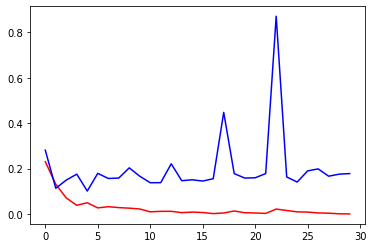

In [12]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#accuracies = {x:[] for x in ['placedates','all','places']}
#for split in ['placedates','all','places']:
#statistics = {x:[] for x in image_datasets}
for split in image_datasets:
  model_ft = models.resnet50(pretrained=True)
  freeze_resnet(model_ft,33)
  num_ftrs=model_ft.fc.in_features
  model_ft.fc=nn.Sequential(  nn.Linear(num_ftrs, 1024),
                              nn.ReLU(),
                              nn.Linear(1024, 2),
                            )
  model_ft=model_ft.to(device)
  criterion = nn.CrossEntropyLoss()
  learner = Learner(model_ft,criterion)

  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 3e-4)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.99)
  learner.set_optimizer(optimizer,scheduler)

  learner.set_datasets(image_datasets[split]['train'],image_datasets[split]['valid'])
  learner.train(30,64,128,batch_cap=64)
  learner.change_to_best_model()

  preds = learner.predict(image_datasets[split]['test'],128,2)
  preds[torch.isnan(preds)]=1
  preds = preds[:,1].numpy() 
  labels = np.array([image_datasets[split]['test'][i][1] for i in range(len(image_datasets[split]['test']))])
  print(accuracy_confidence(preds,labels))

In [0]:
def show_images(indexes,dataset,title=None):  
  """"Use pyplot to show the images of the dataset at indexes
  """
  images = torch.stack([dataset[i][0] for i in indexes.tolist()]) #Stack the images of dataset indexes
  labels = [dataset[i][1] for i in indexes.tolist()]
  plt.ion()
  images = torchvision.utils.make_grid(images)
  inp = images.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated
  print(labels)

In [0]:
show_images()